# 畳み込み演算によるlifegameの生死判定


[Ruby Numo (NUmerical MOdule)](https://github.com/ruby-numo) の[gnuplot-demo/misc/lifegame ](https://github.com/ruby-numo/gnuplot-demo/tree/master/misc/lifegame)のLifeGameクラスを見たとき、とてもシンプルで不思議なコードに引き込まれました。

「これだけのコードでどうやって生死の判定をしているのだろう？」と、

とても興味を持ったところで少し調べてみると「畳み込み演算」らしいことが分かりました。盤面の生死の状態を画素として捉えて、畳み込みフィルタによる画像処理を行うイメージです。好奇心の冷めないうちに、観察の記録をこの iRuby Notebook に書き留めておきます。


次のコードは [class LifeGame](https://github.com/ruby-numo/gnuplot-demo/blob/master/misc/lifegame/lifegame.rb#L4) からクラスの部分を書き出したものです。盤面の初期化(initialize メソッド)と更新(update メソッド)のみのシンプルな構成です。

``` ruby
require 'numo/narray'

class LifeGame

  def initialize(nx,ny,m)
    @data = Numo::UInt8.zeros(ny,nx)
    @data[m..ny-1-m,m..nx-1-m] = Numo::UInt8.new(ny-2*m,nx-2*m).rand(2)
    @step = 0
  end

  def update
    b = Numo::UInt8.zeros(*@data.shape)
    b[1..-2,1..-2] =
      @data[0..-3,0..-3] + @data[0..-3,1..-2] + @data[0..-3,2..-1] +
      @data[1..-2,0..-3] + @data[1..-2,2..-1] +
      @data[2..-1,0..-3] + @data[2..-1,1..-2] + @data[2..-1,2..-1]
    @data.store((b.eq 3) | ((b.eq 2) & Numo::Bit.cast(@data)))
    @step += 1
  end

  attr_reader :data,:step
end
```


## 盤面の初期化

盤面の初期化はinitializeメソッドで行います。以降は小さな盤面を作成し、確認用のコードを直書きしながら確認していきます。

In [1]:
require 'numo/narray'
require 'numo/gnuplot'
require "base64"

data = Numo::UInt8.zeros(6,6)

Numo::UInt8#shape=[6,6]
[[0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0]]

## 盤面の初期値を設定

0は死、1は生の状態を表します。実際のクラスでは盤面の初期状態を乱数によって生成していますが、ここでは1世代目の初期値として「ビーコン」と呼ばれる周期が2の振動子を設定します。 

In [2]:
data[0..5,0..5] =  [[0,0,0,0,0,0], 
                    [0,1,1,0,0,0], 
                    [0,1,1,0,0,0], 
                    [0,0,0,1,1,0],
                    [0,0,0,1,1,0], 
                    [0,0,0,0,0,0]]

[[0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0], [0, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0], [0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0]]

## 盤面をupdate

updateメソッドでは、畳み込み演算用データ b を、 data と同じサイズで初期化。

In [3]:
b = Numo::UInt8.zeros(*data.shape)

Numo::UInt8#shape=[6,6]
[[0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0], 
 [0, 0, 0, 0, 0, 0]]

## 畳み込み演算

畳み込み演算によって 8 方向のデータを畳み込み、セルの生死判定用の数値を作成しています。ここでは配列のビューを指定して操作が行われています。

In [4]:
b[1..-2,1..-2] =
      data[0..-3,0..-3] + data[0..-3,1..-2] + data[0..-3,2..-1] +
      data[1..-2,0..-3] + data[1..-2,2..-1] +
      data[2..-1,0..-3] + data[2..-1,1..-2] + data[2..-1,2..-1]

Numo::UInt8#shape=[4,4]
[[3, 3, 2, 0], 
 [3, 4, 4, 2], 
 [2, 4, 4, 3], 
 [0, 2, 3, 3]]

生死判定用の数値を格納する場所は、実際の盤面サイズより、ひと回り小さな範囲に格納されます。

In [5]:
b

Numo::UInt8#shape=[6,6]
[[0, 0, 0, 0, 0, 0], 
 [0, 3, 3, 2, 0, 0], 
 [0, 3, 4, 4, 2, 0], 
 [0, 2, 4, 4, 3, 0], 
 [0, 0, 2, 3, 3, 0], 
 [0, 0, 0, 0, 0, 0]]

## 2世代目の生死判定

ここで畳み込み演算の結果から2世代目のセルの生死判定を行い、生存データのみを盤面に書き込んでいます。

この1行だけで盤面全体の生死判定ができるとは、なんとシンプルで素敵なことでしょう。

In [6]:
data.store((b.eq 3) | ((b.eq 2) & Numo::Bit.cast(data)))

Numo::UInt8#shape=[6,6]
[[0, 0, 0, 0, 0, 0], 
 [0, 1, 1, 0, 0, 0], 
 [0, 1, 0, 0, 0, 0], 
 [0, 0, 0, 0, 1, 0], 
 [0, 0, 0, 1, 1, 0], 
 [0, 0, 0, 0, 0, 0]]

## 3世代目の生死判定

再びupdateメソッドによって3世代目のセルの生死判定を行います。「ビーコン」は2周期の振動子なので、ここで元の状態に戻ります。

In [7]:
b = Numo::UInt8.zeros(*data.shape)
b[1..-2,1..-2] =
      data[0..-3,0..-3] + data[0..-3,1..-2] + data[0..-3,2..-1] +
      data[1..-2,0..-3] + data[1..-2,2..-1] +
      data[2..-1,0..-3] + data[2..-1,1..-2] + data[2..-1,2..-1]
data.store((b.eq 3) | ((b.eq 2) & Numo::Bit.cast(data)))

Numo::UInt8#shape=[6,6]
[[0, 0, 0, 0, 0, 0], 
 [0, 1, 1, 0, 0, 0], 
 [0, 1, 1, 0, 0, 0], 
 [0, 0, 0, 1, 1, 0], 
 [0, 0, 0, 1, 1, 0], 
 [0, 0, 0, 0, 0, 0]]

## 次世代の生死判定

以後のupdateによって、2周期の振動子はこの状態を繰り返します。

In [8]:
b = Numo::UInt8.zeros(*data.shape)
b[1..-2,1..-2] =
      data[0..-3,0..-3] + data[0..-3,1..-2] + data[0..-3,2..-1] +
      data[1..-2,0..-3] + data[1..-2,2..-1] +
      data[2..-1,0..-3] + data[2..-1,1..-2] + data[2..-1,2..-1]
data.store((b.eq 3) | ((b.eq 2) & Numo::Bit.cast(data)))

Numo::UInt8#shape=[6,6]
[[0, 0, 0, 0, 0, 0], 
 [0, 1, 1, 0, 0, 0], 
 [0, 1, 0, 0, 0, 0], 
 [0, 0, 0, 0, 1, 0], 
 [0, 0, 0, 1, 1, 0], 
 [0, 0, 0, 0, 0, 0]]

#  セルの生死判定について


## 次世代の存在条件

次の世代が存在する条件はつぎの2つです。

*   死んでいるセルに、隣接する生きたセルが3つ存在すれば次の世代が誕生する。
```
(b.eq 3)
```
*   生きているセルに、隣接する生きたセルが2つか3つ存在すれば、次の世代でも生存可能。
```
(Numo::Bit.cast(data) & ((b.eq 2) | (b.eq 3)))
```
それ以外は次世代では生存できない。（死の状態）


これらの条件から、storeする条件式はつぎのようになるはずです。
```
(b.eq 3) | (Numo::Bit.cast(data) & ((b.eq 2) | (b.eq 3)))
```

ところが実際のコードは少し違います。
```
@data.store((b.eq 3) | ((b.eq 2) & Numo::Bit.cast(@data)))
```

## カルノ図で確認

確認のためカルノ図を描いてみます。

図を描きやすいように、予め各条件を`a, b, c`に置き換えます。
```
A = Numo::Bit.cast(data)
B = b.eq 2
C = b.eq 3

C | (A & (B | C))
```

真理値表は次のようになります。

|$A$|$B$|$C$|$OUT$|
|:-:|:-:|:-:|:-:|
|0|0|0| 0 |
|0|0|1| 1 |
|0|1|0| 0 |
|0|1|1| 1 |
|1|0|0| 0 |
|1|0|1| 1 |
|1|1|0| 1 |
|1|1|1| 1 |

真理値表を元にカルノ図を描くと

|$A \backslash BC$|$\overline{B}$|$\overline{B}$|$B$|$B$|
|------|--|--|--|--|
|0     | 0| 1| 1| 0|
|1     | 0| 1| 1| 1|
|      |$\overline{C}$|$C$|$C$|$\overline{C}$|

## 論理圧縮

上記のカルノ図を使って論理圧縮を行うと次のようになります。

```
圧縮前の C | (A & (B | C)) は

圧縮後に C | (A & B) となる。

ここで置き換えを元に戻すと (b.eq 3) | (Numo::Bit.cast(data) & (b.eq 2)) となり
```
この条件は、実際のコードの
```
@data.store((b.eq 3) | ((b.eq 2) & Numo::Bit.cast(@data)))
```
と同じ結果になることがわかります。



# 実際の「ビーコン」の動作を確認

"<img src=\"data:image/gif;base64,R0lGODlh9AH0AfcAAP///wAAAKCgoP8AAADAAACA/8AA/wDu7sBAAMjIAEFp4f/AIACAQMCA/zBggIsAAECAAP+A/3//1KUqKv//AEDg0AAAABoaGjMzM01NTWZmZn9/f5mZmbOzs8DAwMzMzOXl5f////AyMpDukK3Y5vBV8OD//+7dgv+2wa/u7v/XAAD/AABkAAD/fyKLIi6LVwAA/wAAixkZcAAAgAAAzYfO6wD///8A/wDO0f8Uk/9/UPCAgP9FAPqAcumWevDmjL23a7iGC/X13KCAIP+lAO6C7pQA092g3ZBQQFVrL4AUAIAUFIBAFIBAgIBgwIBg/4CAAP+AQP+gQP+gYP+gcP/AwP//gP//wM23nvD/8KC2zcH/wc3AsHz/QKD/IL6+vv////3//fz//Pr/+vn/+ff/9/X/9fT/9PL/8vH/8e//7+3/7ez/7Or/6un/6ef/5+X/5eT/5OL/4uH/4d//393/3dz/3Nr/2tn/2df/19X/1dT/1NL/0tD/0M//z83/zcz/zMr/ysj/yMf/x8X/xcT/xML/wsD/wL//v73/vbz/vLr/urj/uLf/t7X/tbT/tLL/srD/sK//r63/raz/rKr/qqj/qKf/p6X/paT/pKL/oqD/oJ//n53/nZz/nJr/mpj/mJf/l5X/lZT/lJL/kpD/kI//j43/jYz/jIr/ioj/iIf/h4X/hYT/hIL/goD/gH//f33/fXv/e3r/enj/eHf/d3X/dXP/c3L/cnD/cG//b23/bWv/a2r/amj/aGf/Z2X/ZWP/Y2L/YmD/YF//X13/XVv/W1r/Wlj/WFf/V1X/VVP/U1L/UlD/UE//T03/TUv/S0r/Skj/SEf/R0X/RUP/Q0L/QkD/QD//Pz3/PTv/Ozr/Ojj/ODf/NzX/NTP/MzL/MjD/MC//Ly3/LSv/Kyr/Kij/KCb/JiX/JSP/IyL/IiD/IB7/Hh3/HRv/Gxr/Ghj/GBb/FhX/FRP/ExL/EhD/EA7/Dg3/DQv/Cwr/Cgj/CAb/BgX/BQP/AwL/AgD/ACH/C05FVFNDQVBFMi4wAwEAAAAh+QQEMgD/ACwAAAAA9AH0AYf///8AAACgoKD/AAAAwAAAgP/AAP8A7u7AQADIyABBaeH/wCAAgEDAgP8wYICLAABAgAD/gP9//9SlKir//wBA4NAAAAAaGhozMzNNTU1mZmZ/f3+ZmZmzs7PAwMDMzMzl5eX////wMjKQ7pCt2ObwVfDg///u3YL/tsGv7u7/1wAA/wAAZAAA/38iiyIui1cAAP8AAIsZGXAAAIAAAM2HzusA////AP8AztH/FJP/f1DwgID/RQD6gHLplnrw5oy9t2u4hgv19dyggCD/pQDugu6UANPdoN2QUEBVay+AFACAFBSAQBSAQICAYMCAYP+AgAD/gED/oED/oGD/oHD/wMD//4D//8DNt57w//Cgts3B/8HNwLB8/0Cg/yC+vr7////9//38//z6//r5//n3//f1//X0//Ty//Lx//Hv/+/t/+3s/+zq/+rp/+nn/+fl/+Xk/+Ti/+Lh/+Hf/9/d/93c/9za/9rZ/9nX/9fV/9XU/9TS/9LQ/9DP/8/N/83M/8zK/8rI/8jH/8fF/8XE/8TC/8LA/8C//7+9/728/7y6/7q4/7i3/7e1/7W0/7Sy/7Kw/7Cv/6+t/62s/6yq/6qo/6in/6el/6Wk/6Si/6Kg/6Cf/5+d/52c/5ya/5qY/5iX/5eV/5WU/5SS/5KQ/5CP/4+N/42M/4yK/4qI/4iH/4eF/4WE/4SC/4KA/4B//399/317/3t6/3p4/3h3/3d1/3Vz/3Ny/3Jw/3Bv/29t/21r/2tq/2po/2hn/2dl/2Vj/2Ni/2Jg/2Bf/19d/11b/1ta/1pY/1hX/1dV/1VT/1NS/1JQ/1BP/09N/01L/0tK/0pI/0hH/0dF/0VD/0NC/0JA/0A//z89/z07/zs6/zo4/zg3/zc1/zUz/zMy/zIw/zAv/y8t/y0r/ysq/yoo/ygm/yYl/yUj/yMi/yIg/yAe/x4d/x0b/xsa/xoY/xgW/xYV/xUT/xMS/xIQ/xAO/w4N/w0L/wsK/woI/wgG/wYF/wUD/wMC/wIA/wAI/gABCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5Ajzw0gkLJAAQECgPC54aOACwEuCJBMOqxlggFG/zy9EcQFDwA8vC5NmyvrykFvZ9ygGoAADbWDY7VMPPNp2aFhD/SAITTmgRtAB9CwGUBq0K8/Z1aNfPZBzJkx/mw2brm7cuvaMZxPKH4gCAzC41MlPpC169Gyq7uGDV7ghvYgbACcde1tEEB7z90X2wXVFZTaZRfgJpCC+VX2oGzKkWecQBES1KF8IDpFn4QCadDbbyWeaBmDqFWmHAgBnEeZiQOhaFCMNw5E42UDBtAZjwvdpluIRBo1onUeNugah0qy5oEH0R2JZH0AsDjhhwRpgIEA651mJQBLWqcklgcJWeSZSB3JmoaZkSihbBeYCKOba1rHJkIaSFfdaWxKOWVCZJKJ5qCrkcjal0m6t2Jvc/7pKGWILgTCZyRGWtmYFmooUHsTwkfop4X+ydqOsXlK6nOOolonlaQyx9CR/q16+iCQCvFW44+g5qqTmgQp+J5q+y1oGQYbbKYdnS36uuVBy/q2ogebKatacr5ZWlCwFeqq7U28EtRdb6U6Z9l7oakn5arfIkTudv61Kaxo9UXJ6ULawbvtvU6FidOQ+PZrlWjRNruvvwRnxRx24HJb8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfsMmTk2vvyzEapB6bANOf8kwCMCqrzzzjNC/TQPDHYnMxEJ03TgbC9t57SULs0a6lRVy21gw71qfXWXHft9ddghy322GSXbfbZaKet9tpst+222Uohym+OAytct9141zQ3/kx7A2WrQK421PfVeeud0+AtIb6S4osrFazTWR9+t02Mq1R5SpeflLnmSzHn3EObmxQ6SaOTLvnkS5/eVekjsR6S66+rTjnqqXsFu9Xx3V6U7rjXxvtQv/dOWvC5Cb8w8UAhb7xjyvvU/PKLPc+T9NAjRv2u1fd7vezZ67o97d1/+n3h4Yv/1fjl+4W+4ennun7t7Ztve/ygvj+T/fTbhX9M++c/2fn+G1T/XjLAAL6lgIkz4JkQyBIGKlAtDrTcA4kUQcxNMEQVREkGLziWDYqOg/LxYElECML5mbCEvgMgClN4whUOT4UufGELYwgZEraOhjJcHQ4lY0OR9HCH/lP5IUiECESoENEjRyxiU5LIESYqUSlO1EgUn3iUKWLEilQkChYtssUsFm+GXixMFykyxjD2pIwSQaMZsQfGNQZGjRCBoxtnlxQYaUpwcxSjUgIXETnm8X5KEQCu4vjHwWyRVIQs5BuVgoE8MQ10ilxkUi5QLDBp4GkJ8WMkCdeU90Ruk+ozYtbuCEq53OkpPitTKfuyxS95YECvWiVftvibaF3yk7LMSxfTg8lM5lIvmozlL/ESzCANk5gwPCZdiqkQZipziMl8ZlyciRBqSrOJ0bymW6xJN23ChZtY8+Y3sylOCJKznGgBZ4vQ2RZ1UomdbHGnm+CZznPSs4P2/rynafKpT37Op5/1bCNAwSJPRw1ULAUt6EG7aZuFkiWhDsWnQJuygopa9KIYzahGN8rRjnr0oyANqUdNBlGqiPSkKE2pSlc60pKVdCosjalMZ0rTFZDUn0mpqU53ytOM3nSiTOmpUIcq05/q0KRETa
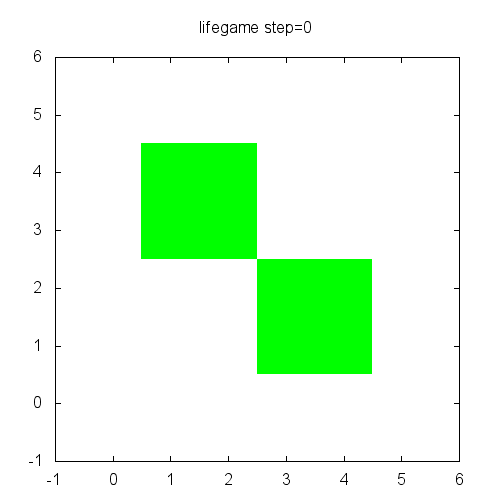

In [9]:
require 'numo/narray'
require 'numo/gnuplot'
require "base64"

class LifeGameTest

  def initialize(nx,ny,m)
    @data = Numo::UInt8.zeros(ny,nx)
    @data[0..5,0..5] =  [[0,0,0,0,0,0], 
                         [0,1,1,0,0,0], 
                         [0,1,1,0,0,0], 
                         [0,0,0,1,1,0],
                         [0,0,0,1,1,0], 
                         [0,0,0,0,0,0]]
    #@data[m..ny-1-m,m..nx-1-m] = Numo::UInt8.new(ny-2*m,nx-2*m).rand(2)
    @step = 0
  end

  def update
    b = Numo::UInt8.zeros(*@data.shape)
    b[1..-2,1..-2] =
      @data[0..-3,0..-3] + @data[0..-3,1..-2] + @data[0..-3,2..-1] +
      @data[1..-2,0..-3] + @data[1..-2,2..-1] +
      @data[2..-1,0..-3] + @data[2..-1,1..-2] + @data[2..-1,2..-1]
    @data.store((b.eq 3) | ((b.eq 2) & Numo::Bit.cast(@data)))
    @step += 1
  end

  attr_reader :data,:step
end

nx,ny = 6, 6 # don't modify
life = LifeGameTest.new(nx,ny,1)
filename = "lifegameTest.gif" 

Numo.gnuplot do
  reset
  set output: filename
  set term: "gif", animate:true, delay:50, size:[500,500]
  set :nokey
  set size: {ratio:1.0*ny/nx}
  set xrange: -1..nx
  set yrange: -1..ny
  unset :colorbox
  set palette_defined:'(0 "white", 1 "green")'

  10.times do |i|
    life.update if i > 0
    set title:"lifegame step=#{i}"
    plot life.data, :flipy, with:"image"
  end
  set :output
end

img = Base64.strict_encode64(File.binread(filename))
IRuby.html %Q(<img src="data:image/gif;base64,#{img}" />)

# まとめ

numo-gnuplotで出会ったlifegameから、新しい知見を得ることができました。

感謝！

### 参考

*   [ruby-numo/gnuplot: Gnuplot wrapper for Ruby/Numo](https://github.com/ruby-numo/gnuplot)
*   [ruby-numo/gnuplot-demo: Ruby/Numo::Gnuplot Demo](https://github.com/ruby-numo/gnuplot-demo)
*   [ruby-numo/narray: Ruby/Numo::NArray - New NArray class library](https://github.com/ruby-numo/narray)


